# Functionality of the `markov` module

The `markov` module is a _symbolic Markov chain calculator_. It accepts symbolic matrices, as `sympy.Matrix` objects, as the primitives of the Markov chain. It can parse such matrices from native lists or from files, as well as recognizing a syntax to easily fill in entries of the matrix. The module then has numerous functions which symbolically compute the finite/infinite horizon total rewards (which encompasses, for example, total cost or net monetary benefit) or incremental cost-effectiveness ratios (ICERs), and can generate inequalities or pairwise comparisons of them.

In this notebook, we will demonstrate these features.

## Imports

In [2]:
from markovag import markov
from sympy import Symbol
from sympy import var
from sympy.matrices import Matrix, eye, zeros
from sympy.plotting import PlotGrid

## Parsing a symbolic matrix

`markov.parse_matrix()` takes a list, or list of lists, and parses it into a symbolic matrix. Numbers can either be passed in strings or as numbers.

In [64]:
markov.parse_matrix(['0.5', '0.5', '0'])

Matrix([
[0.5],
[0.5],
[  0]])

In [63]:
markov.parse_matrix(
     [['0.5', '0.5', '0'],
     ['0.3', '0.2', '0.5'],
     ['0.1', '0.5', '0.4']]
     )

Matrix([
[0.5, 0.5,   0],
[0.3, 0.2, 0.5],
[0.1, 0.5, 0.4]])

In [65]:
markov.parse_matrix(
     [[0.5, 0.5, 0],
     [0.3, 0.2, 0.5],
     [0.1, 0.5, 0.4]]
     )

Matrix([
[0.5, 0.5,   0],
[0.3, 0.2, 0.5],
[0.1, 0.5, 0.4]])

The above examples don't have any variables. The real power of `parse_matrix()` comes from being able to handle _symbols_. In the example below, $a$ and $b$ will be treated as variables, i.e., free parameters.

In [67]:
markov.parse_matrix(
     [['a', 'b', 0],
     [0.3, 0.2, 0.5],
     [0.1, 0.5, 0.4]]
     )

Matrix([
[  a,   b,   0],
[0.3, 0.2, 0.5],
[0.1, 0.5, 0.4]])

If we have a large matrix, we may not want to manually specify the names of each variable. `parse_matrix()` accepts a '?' symbol and will automatically create a variable for that entry. By default, the new variables that are created are $\tau$, indexed by the row and how many variables are in that row.

In [69]:
markov.parse_matrix(
     [['?', '?', 0],
     [0.3, '?', 0.5],
     [0.1, 0.5, 0.4]]
     )

Matrix([
[tau_1_1, tau_1_2,   0],
[    0.3, tau_2_1, 0.5],
[    0.1,     0.5, 0.4]])

You can specify another new variable symbol with the parameter `new_variable_name`.

In [70]:
markov.parse_matrix(['?', '?', 0], new_var_name='x')

Matrix([
[x_1],
[x_2],
[  0]])

Another useful syntax that `parse_matrix()` recognizes is the '\*' character. This is helpful for the stochasticity of the vector or matrix. An element with a '\*' is "filled in" with the remaining probability mass evenly distributed among all '\*' elements. In the Markov chain context, this makes inputting the initial distribution vector or the transition probability matrix very easy.

In [1]:
[['?', '?', '*'],
['*', '?', 0.5],
['*', '*', '?']]

[['?', '?', '*'], ['*', '?', 0.5], ['*', '*', '?']]

In [74]:
markov.parse_matrix(
     [['?', '?', '*'],
     ['*', '?', 0.5],
     ['*', '*', '?']]
     )

Matrix([
[        tau_1_1,         tau_1_2, -tau_1_1 - tau_1_2 + 1],
[  0.5 - tau_2_1,         tau_2_1,                    0.5],
[1/2 - tau_3_1/2, 1/2 - tau_3_1/2,                tau_3_1]])

In [75]:
markov.parse_matrix(['?', '?', '*'])

Matrix([
[             tau_1],
[             tau_2],
[-tau_1 - tau_2 + 1]])

The function also accepts a `file` parameter, where it will read the contexts of a csv, and then just run `parse_matrix()` on the file's contents.

## Calculations with symbolic Markov chains

All Markov reward chains require three primitives: $P$, the probability transition matrix, $\pi$, the initial distribution vector, and $R$, the reward vector.

In [82]:
P = markov.parse_matrix(
     [['?', '?', '*'],
     ['*', '?', 0.5],
     ['*', '*', '?']]
     , new_var_name = 'p')
pi = markov.parse_matrix(['?', '?', '*'], new_var_name='pi')
R = markov.parse_matrix(['?', '?', 0], new_var_name='r')

In [83]:
P

Matrix([
[        p_1_1,         p_1_2, -p_1_1 - p_1_2 + 1],
[  0.5 - p_2_1,         p_2_1,                0.5],
[1/2 - p_3_1/2, 1/2 - p_3_1/2,              p_3_1]])

In [84]:
pi

Matrix([
[            pi_1],
[            pi_2],
[-pi_1 - pi_2 + 1]])

In [85]:
R

Matrix([
[r_1],
[r_2],
[  0]])

There are functions for the finite horizon and infinite horizon reward, which requires you to pass the Markov chain primitives, a discount rate, and, if finite-horizon, then the horizon.

In [90]:
markov.finite_horizon_reward(P, pi, R, discount=0.95, horizon=5)

r_1*(pi_1*(0.7737809375*p_1_1**5 + 1.547561875*p_1_1**4*p_3_1 - 0.733055625*p_1_1**4 - 3.09512375*p_1_1**3*p_1_2*p_2_1 + 1.547561875*p_1_1**3*p_1_2*p_3_1 - 1.16067140625*p_1_1**3*p_2_1*p_3_1 + 1.16067140625*p_1_1**3*p_2_1 + 1.741007109375*p_1_1**3*p_3_1**2 - 2.066809609375*p_1_1**3*p_3_1 + 1.1831775*p_1_1**3 - 2.3213428125*p_1_1**2*p_1_2*p_2_1**2 - 3.48201421875*p_1_1**2*p_1_2*p_2_1*p_3_1 + 2.199166875*p_1_1**2*p_1_2*p_2_1 + 2.3213428125*p_1_1**2*p_1_2*p_3_1**2 - 1.0995834375*p_1_1**2*p_1_2*p_3_1 - 0.7737809375*p_1_1**2*p_2_1**2*p_3_1 + 0.7737809375*p_1_1**2*p_2_1**2 - 1.16067140625*p_1_1**2*p_2_1*p_3_1**2 + 2.2806175*p_1_1**2*p_2_1*p_3_1 - 1.11994609375*p_1_1**2*p_2_1 + 1.16067140625*p_1_1**2*p_3_1**3 - 2.46388140625*p_1_1**2*p_3_1**2 + 1.722787890625*p_1_1**2*p_3_1 + 0.482922109375*p_1_1**2 + 2.3213428125*p_1_1*p_1_2**2*p_2_1**2 - 2.3213428125*p_1_1*p_1_2**2*p_2_1*p_3_1 + 0.580335703125*p_1_1*p_1_2**2*p_3_1**2 - 1.547561875*p_1_1*p_1_2*p_2_1**3 - 0.7737809375*p_1_1*p_1_2*p_2_1**2*p_3

The infinite-horizon reward function does not invert the matrix. Instead, it uses the alternative definition of inverting a matrix: $M^{-1} = adj(M) / det(M)$. Recall that in the paper, this reformulation allows us to still write infinite-horizon inequalities as polynomial systems. So, this function returns a list of size 2: the 'numerator' and the 'denominator', both of which are polynomials.

In fact, this is a design choice implemented throughout this package. As we argued in the paper, all standard analyses of a Markov reward chain are, if not polynomials, _ratios_ of polynomials. So, any of those analyses return a list of 2, with the numerator and denominator. We will see this with the ICER functions.

In [91]:
markov.infinite_horizon_reward(P, pi, R, 0.95)

(r_1*(pi_1*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.724375*p_3_1 + 0.774375) + pi_2*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.676875*p_3_1 + 0.700625) + (-pi_1 - pi_2 + 1)*(0.9025*p_2_1*p_3_1 - 0.9025*p_2_1 - 0.700625*p_3_1 + 0.700625)) + r_2*(pi_1*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.49875*p_1_2 - 0.45125*p_3_1 + 0.45125) + pi_2*(0.45125*p_1_1*p_3_1 - 0.49875*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.49875*p_3_1 + 0.54875) + (-pi_1 - pi_2 + 1)*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.475*p_3_1 + 0.475)),
 0.0451250000000001*p_1_1*p_2_1 + 0.0225625000000001*p_1_1*p_3_1 - 0.0700625000000001*p_1_1 + 0.0451250000000001*p_1_2*p_2_1 - 0.0225625*p_1_2*p_3_1 + 0.0451250000000001*p_2_1*p_3_1 - 0.0926250000000001*p_2_1 - 0.0587812500000001*p_3_1 + 0.10878125)

We can also easily create equalities or inequalities of these functions. By default, it assumes the relation $\geq 0$. But, we can specify any other relation with the `relation` parameter, which accepts a list: the first element is a symbol from $\{<,>,>=,<=,= \}$ and the second element is the expression on the right-hand side. It will return an equivalent polynomial inequality where $0$ is on the right-hand side.

In [93]:
markov.infinite_horizon_reward_ineq(P, pi, R, 0.95)

r_1*(pi_1*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.724375*p_3_1 + 0.774375) + pi_2*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.676875*p_3_1 + 0.700625) + (-pi_1 - pi_2 + 1)*(0.9025*p_2_1*p_3_1 - 0.9025*p_2_1 - 0.700625*p_3_1 + 0.700625)) + r_2*(pi_1*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.49875*p_1_2 - 0.45125*p_3_1 + 0.45125) + pi_2*(0.45125*p_1_1*p_3_1 - 0.49875*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.49875*p_3_1 + 0.54875) + (-pi_1 - pi_2 + 1)*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.475*p_3_1 + 0.475)) >= 0

In [94]:
markov.infinite_horizon_reward_ineq(P, pi, R, 0.95, relation=['<', 5])

-0.225625*p_1_1*p_2_1 - 0.1128125*p_1_1*p_3_1 + 0.3503125*p_1_1 - 0.225625*p_1_2*p_2_1 + 0.1128125*p_1_2*p_3_1 - 0.225625*p_2_1*p_3_1 + 0.463125000000001*p_2_1 + 0.29390625*p_3_1 + r_1*(pi_1*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.724375*p_3_1 + 0.774375) + pi_2*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.676875*p_3_1 + 0.700625) + (-pi_1 - pi_2 + 1)*(0.9025*p_2_1*p_3_1 - 0.9025*p_2_1 - 0.700625*p_3_1 + 0.700625)) + r_2*(pi_1*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.49875*p_1_2 - 0.45125*p_3_1 + 0.45125) + pi_2*(0.45125*p_1_1*p_3_1 - 0.49875*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.49875*p_3_1 + 0.54875) + (-pi_1 - pi_2 + 1)*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.475*p_3_1 + 0.475)) - 0.54390625 < 0

We can compute an expression for the ICER as well. The ICER function computes the ICER of intervention B compared to intervention A. Recall that the ICER is the difference in costs divided by the difference in benefits. In the finite-horizon case, this is clearly a ratio of polynomials. In the infinite-horizon case, through using the alternative inverse definition and some factoring, we can also get it into a ratio of polynomials. As before, we return the numerator and denominator.

In [125]:
markov.infinite_horizon_icer(P_a=P, pi_a=pi, cost_a=markov.parse_matrix([1,1,0]), benefit_a=R,
    P_b=P, pi_b=pi, cost_b=markov.parse_matrix([10,10,10]), benefit_b=R + 5 * Matrix.ones(3,1), discount=0.95)

(-(pi_1*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.724375*p_3_1 + 0.774375) + pi_1*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.49875*p_1_2 - 0.45125*p_3_1 + 0.45125) + pi_2*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.676875*p_3_1 + 0.700625) + pi_2*(0.45125*p_1_1*p_3_1 - 0.49875*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.49875*p_3_1 + 0.54875) + (-pi_1 - pi_2 + 1)*(0.9025*p_2_1*p_3_1 - 0.9025*p_2_1 - 0.700625*p_3_1 + 0.700625) + (-pi_1 - pi_2 + 1)*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.475*p_3_1 + 0.475))*(0.0451250000000001*p_1_1*p_2_1 + 0.0225625000000001*p_1_1*p_3_1 - 0.0700625000000001*p_1_1 + 0.0451250000000001*p_1_2*p_2_1 - 0.0225625*p_1_2*p_3_1 + 0.0451250000000001*p_2_1*p_3_1 - 0.0926250000000001*p_2_1 - 0.0587812500000001*p_3_1 + 0.10878125) + (0.0451250000000001*p_1_1*p_2_1 + 0.0225625000000001*p_1_1*p_3_1 - 0.0700625000000001*p_1_1 + 0.0451250000000001*p_1_2*p_2_1 - 0.0225625*p_1_2*p_3_1 + 0.0451250000000001*p_2_1*p_3_1 - 0.

We can then also make an inequality of the ICER. For example, often we want the ICER to be below $50,000.

In [127]:
markov.infinite_horizon_icer_ineq(P_a=P, pi_a=pi, cost_a=markov.parse_matrix([1,1,0]), benefit_a=R,
    P_b=P, pi_b=pi, cost_b=markov.parse_matrix([10,10,10]), benefit_b=R + 5 * Matrix.ones(3,1), discount=0.95, relation=['<=', 50000])

50000*(r_1*(pi_1*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.724375*p_3_1 + 0.774375) + pi_2*(0.9025*p_2_1*p_3_1 - 0.95*p_2_1 - 0.676875*p_3_1 + 0.700625) + (-pi_1 - pi_2 + 1)*(0.9025*p_2_1*p_3_1 - 0.9025*p_2_1 - 0.700625*p_3_1 + 0.700625)) + r_2*(pi_1*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.49875*p_1_2 - 0.45125*p_3_1 + 0.45125) + pi_2*(0.45125*p_1_1*p_3_1 - 0.49875*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.49875*p_3_1 + 0.54875) + (-pi_1 - pi_2 + 1)*(0.45125*p_1_1*p_3_1 - 0.45125*p_1_1 - 0.45125*p_1_2*p_3_1 + 0.45125*p_1_2 - 0.475*p_3_1 + 0.475)))*(0.0451250000000001*p_1_1*p_2_1 + 0.0225625000000001*p_1_1*p_3_1 - 0.0700625000000001*p_1_1 + 0.0451250000000001*p_1_2*p_2_1 - 0.0225625*p_1_2*p_3_1 + 0.0451250000000001*p_2_1*p_3_1 - 0.0926250000000001*p_2_1 - 0.0587812500000001*p_3_1 + 0.10878125) - 50000*(5*pi_1*(0.9025*p_1_1*p_2_1 - 0.95*p_1_1 + 0.9025*p_1_2*p_2_1 - 0.49875*p_1_2 - 0.9025*p_2_1 + 0.95) + 5*pi_2*(0.9025*p_1_1*p_2_1 - 0.9025*p_1_1 + 0.9025*p_1_2*p_2_

You can see that these expressions get very messy, even for a simple 3-state Markov chain with some free parameters! However, the key insight of our paper is we can construct _cylindrical algbraic decompositions_ of such a system and be able to easily understand it. See the `cad` module.

The last thing we will demonstrate is that we can perform a pairwise comparison of two interventions by their reward. The functions `finite_horizon_reward_paired()` and `infinite_horizon_reward_paired()` return the inequality representing the total reward of intervention B being $\geq$ the total reward of intervention A. This is helpful to, for example, compare net monetary benefits, as we may require the NMB of B to be greater than A if we are to fund it.

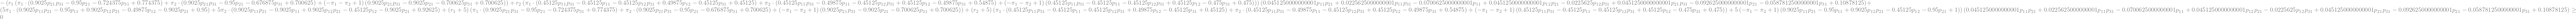

In [155]:
markov.infinite_horizon_reward_paired(P_a=P, pi_a=pi, reward_a=R,
    P_b=P, pi_b=pi, reward_b=R + 5 * Matrix.ones(3,1), discount=0.95)

## Plotting

The module also provides an easy-to-use plotting function, `plot_simple()`. For more control over plotting, consult `sympy.plotting`, but for getting started fast, `plot_simple()` should suffice. It can plot 2-way or 3-way sensitivity analyses. The '-way' of the sensitivity analysis is controlled by the parameter `nvar`. In order to specify which variable is on the x axis and which is on the y axis, pass a 3-tuple for `x_var` and `y_var`, with the format `(var, min, max)`. There are also many other keyword arguments one can pass which will be automatically passed to `sympy.plotting`. Consult that documentation for more information, especially about aesthetics and labels.

If `nvar==2`, then the parameter plottype can either be 'region' or 'boundary'. If it is 'region', it will plot the entire region over which the inequality holds; if it is boundary, it will convert the inequality into an equality first and then just plot the boundary.

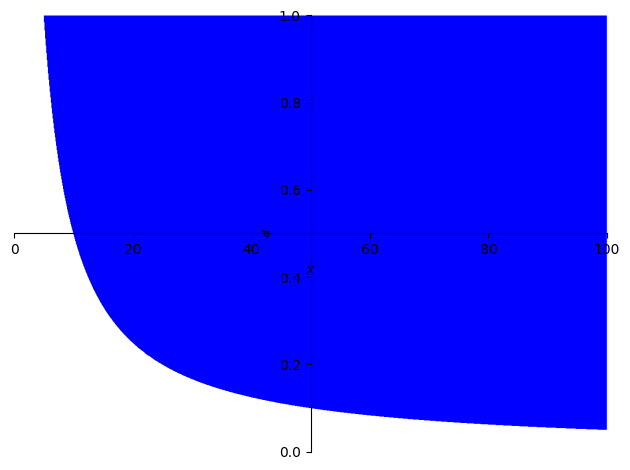

In [166]:
var('a,b,x')
markov.plot_simple(a*x >= 5, x_var=(x, 0, 1e2), y_var=(a, 0, 1))

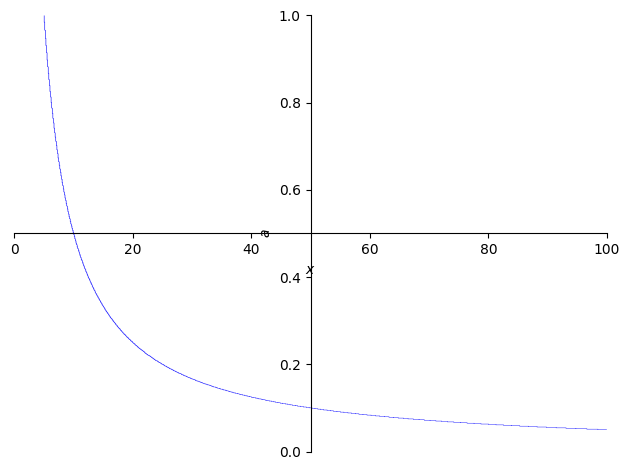

In [167]:
markov.plot_simple(a*x >= 5, plottype='boundary', x_var=(x, 0, 1e2), y_var=(a, 0, 1))

You can also specify additional constraints, by passing a list with the `constraints` parameter, which will be conjuncted with the inequality. You can actually get pretty far with just this type of plotting. The plots generated by `sympy.plotting` use a wonderful algorithm which is called _adapted mesh_, instead of the usual fixed mesh that we would naively use if we were using `numpy` and `matplotlib`. 

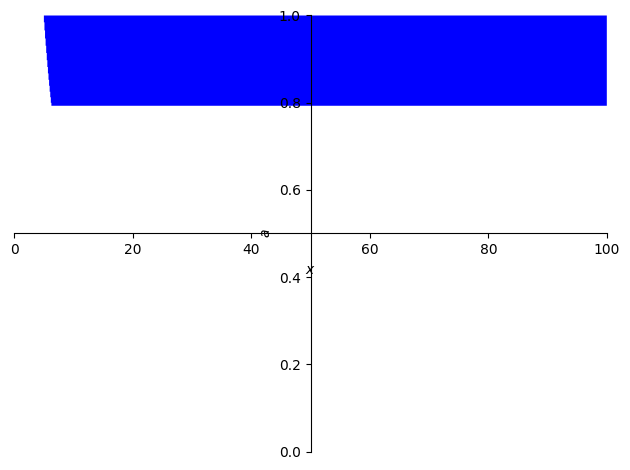

In [172]:
markov.plot_simple(a*x >= 5, constraints=[a**3 > 0.5], plottype='region', x_var=(x, 0, 1e2), y_var=(a, 0, 1))

We can also do 3-way sensitivity analyses. There are two possibilities for `plottype` here. It can either be 'boundary' or 'facet'. Unfortunately, `sympy.plotting` does not allow for plotting implicit equalities or inequalities with 3 variables. So, if 'boundary' is chosen, the equality is first solved for a certain variable, indicated by the `z_var` parameter, and then this surface, as a function of the remaining two variables, is plotted in 3-dimensions.

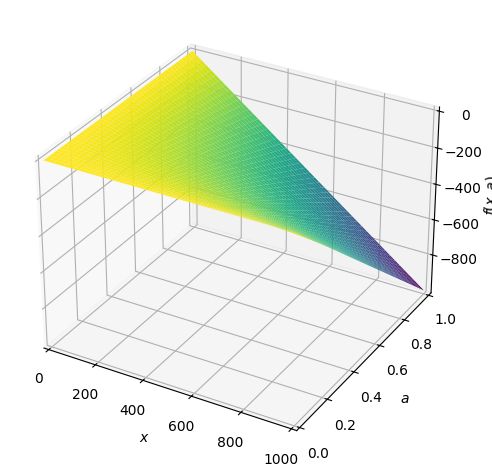

In [177]:
markov.plot_simple(a*x + b >= 2, nvar=3, plottype='boundary', z_var=b, x_var=(x,0,1000), y_var=(a,0,1))

Over the indicated surface, the equality holds. The inequality holds either above or below this surface, indicated by the coefficients.

We can also plot slices of this surface by using the 'facet' option for `plottype`. If this option is chosen, then we must pass `z_var`, as when we chose 'boundary', and also a list for the `facet_options` parameter, in the format [z_label, (value, color), (value, color)...]. The first element is the label with which to print the z-variable symbol in each facet, and the following tuples are which values for the z-variable to take slices at, and which colors to draw it in. With these options, the function returns a list of plots. These can then be arranged using `sympy.plotting.PlotGrid`. Of course, they are just `matplotlib` plots so can be arranged with other methods too.

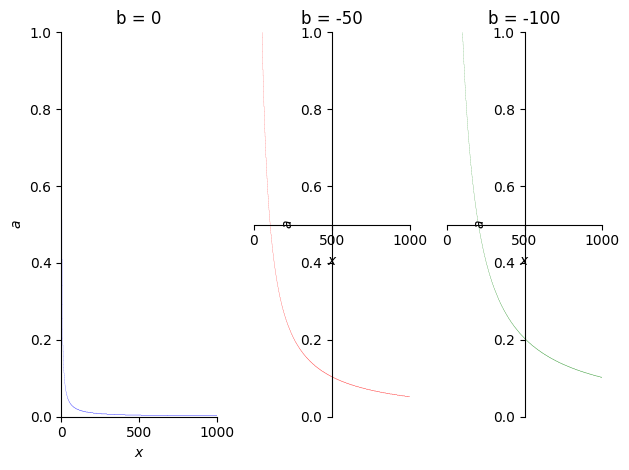

In [189]:
plots = markov.plot_simple(a*x + b >= 2, nvar=3, plottype='facet', z_var=b,
facet_options = ['b', (0, 'blue'), (-50, 'red'), (-100, 'green')], x_var=(x,0,1000), y_var=(a,0,1))

PlotGrid(1,3, *plots)

## Bringing it all together in a CEA

We can combine these steps to very quickly conduct a sensitivity analysis of a CEA. We will have a 3-state Markov chain, with states being 'healthy', 'sick', and 'death', and from the two alive states, the only free probability is the probability of death, with the remaining probability mass distributed evenly. Everyone starts off as healthy. We normalize the reward of being healthy to 1, and the reward of being dead is 0, but we don't know the reward of being sick.

In [3]:
P = markov.parse_matrix([['*', '*', '?'], ['*', '*', '?'], [0,0,1]])
pi = markov.parse_matrix([1,1,0])
R = markov.parse_matrix([1, '?', 0], new_var_name='x')

ineq = markov.infinite_horizon_reward_ineq(P, pi, R, 0.95, ['>=', 5])

In [4]:
ineq

-0.11875*tau_1_1 - 0.11875*tau_2_1 + 0.05*x_1 + 0.0375 >= 0

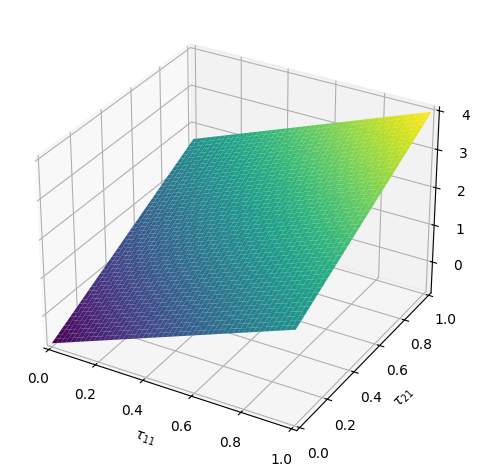

In [271]:
markov.plot_simple(ineq, nvar=3, plottype='boundary', z_var=Symbol('x_1'), x_var=(Symbol('tau_1_1'), 0, 1), y_var=(Symbol('tau_2_1'), 0, 1))

The z-axis is the reward for being sick. But, we may reasonably believe this should be less than 1, i.e., less than the reward for being healthy. It is difficult to cut off the surface at z=1 visually. So, we may construct some facets.

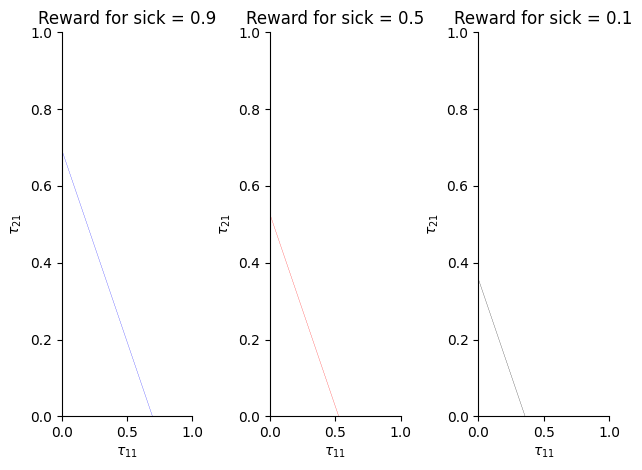

In [275]:
plots = markov.plot_simple(ineq, nvar=3, plottype='facet', z_var=Symbol('x_1'), facet_options=['Reward for sick', (0.9, 'blue'), (0.5, 'red'), (0.1, 'black')],
x_var=(Symbol('tau_1_1'), 0, 1), y_var=(Symbol('tau_2_1'), 0, 1))

PlotGrid(1,3, *plots)

So, as the reward for being sick goes down, in order to maintain the inequality, the isoquant curve of $\tau_{11}$ and $\tau_{21}$ shifts closer to 0. Essentially, both mortalities have to go down in order to maintain the inequality.

Let's say we fix the reward for being sick to 0.5, and analyze the mortalities more carefully.

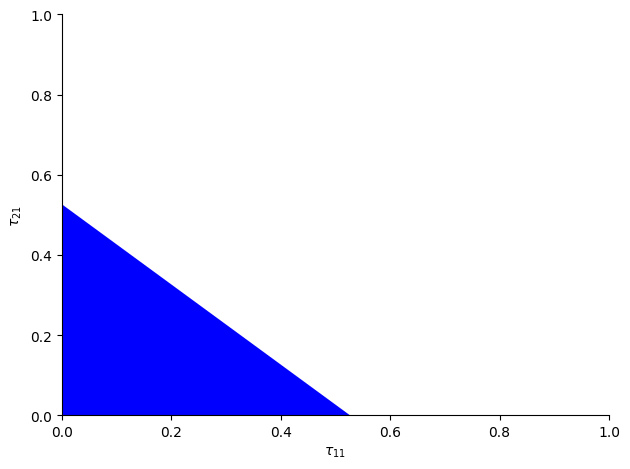

In [280]:
ineq_subbed = ineq.subs(Symbol('x_1'), 0.5)

markov.plot_simple(ineq_subbed, x_var=(Symbol('tau_1_1'), 0, 1), y_var=(Symbol('tau_2_1'), 0, 1))

This isn't that surprising, we just saw this in the facet plot. But, in 2d, we can specify constraints and create more complicated plots. For example, we may reasonably assume that the mortality when being sick is at least the mortality when being healthy.

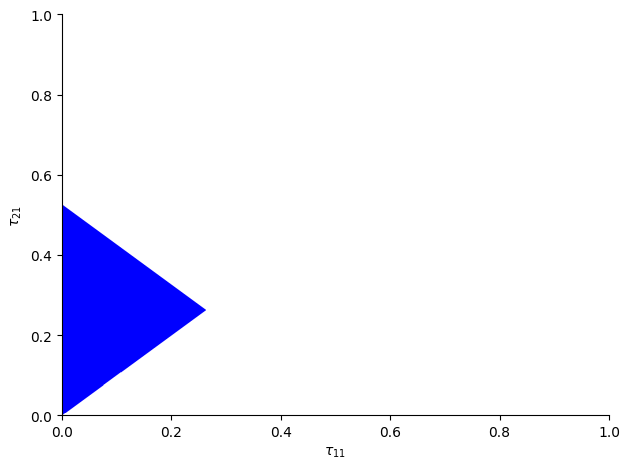

In [282]:
markov.plot_simple(ineq_subbed, constraints=[Symbol('tau_2_1') >= Symbol('tau_1_1')], x_var=(Symbol('tau_1_1'), 0, 1), y_var=(Symbol('tau_2_1'), 0, 1))

As we have demonstrated, you can get pretty far doing a CEA symbolically and with various plots, powered by this package.